# Preprocessing of the CPDB network
In this notebook, I want to collect the protein-protein-interaction (PPI) network from ConsensusPathDB and preprocess it.
The preprocessing contains the following steps:
* Filter out "complex" interactions (more than two partners)
* Filter out interactions with score < 0.5
* Map the strange uniprot gene names to ENSEMBL IDs (either protein IDs or gene IDs)
* Convert the resulting edgelist to an adjacency matrix
* Export the edgelist to .sif (can be read by cytoscape directly)

I downloaded the CPDB network from [here](http://cpdb.molgen.mpg.de/download/ConsensusPathDB_human_PPI.gz) on 2021.06.05.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mygene
import h5py
import networkx as nx
import seaborn as sns
%matplotlib inline

In [2]:
def save_sif(edgelist, outfile):
    print ("Saving edgelist to {}".format(outfile))
    with open(outfile, 'w') as out:
        for idx, row in edgelist.iterrows():
            out.write('{} (interacts) {}\n'.format(row.partner1, row.partner2))
    print (".sif successfully saved!")

 # get Ensembl IDs for gene names
def get_gene_symbols(list_of_ensembl_ids):
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)#discard rows with null values
    return node_names



In [3]:
interactions = pd.read_csv('../data/ppi/ConsensusPathDB_human_PPI.gz',
                           compression='gzip',
                           header=1,
                           sep='\t',
                           encoding='utf8'
                          )
interactions_nona = interactions.dropna()
interactions_nona.head()

,# source_databases,interaction_publications,interaction_participants__uniprot_entry,interaction_participants__uniprot_id,interaction_participants__genename,interaction_participants__hgnc_id,interaction_participants__entrez_gene,interaction_participants__ensembl_gene,interaction_confidence
8,"PhosphoPOINT,Reactome,HPRD,Spike,Biogrid","1660465,16713569,12547834","ANPRA_HUMAN,ANF_HUMAN","P16066,P01160","NPR1,NPPA","HGNC:7943,HGNC:7939","4881,4878","ENSG00000169418,ENSG00000175206",0.192576
9,"HPRD,Reactome,PhosphoPOINT,Biogrid","1660465,12709393,1672777,1309330","ANFC_HUMAN,ANPRB_HUMAN","P23582,P20594","NPPC,NPR2","HGNC:7941,HGNC:7944","4880,4882","ENSG00000163273,ENSG00000159899",0.230184
24,"DIP,Reactome,IntAct","22210847,17486119,21408196,16906149,19897728","STIM1_HUMAN,TRPC1_HUMAN","Q13586,P48995","STIM1,TRPC1","HGNC:11386,HGNC:12333","6786,7220","ENSG00000167323,ENSG00000144935",0.597177
25,"Reactome,HPRD",11591728,"AT2B4_HUMAN,NOS1_HUMAN","P23634,P29475","ATP2B4,NOS1","HGNC:817,HGNC:7872","493,4842","ENSG00000058668,ENSG00000089250",0.520836
26,"BIND,HPRD,CORUM,MIPS-MPPI,Reactome,IntAct","10093054,9831708,23587463","ABCC9_HUMAN,KCJ11_HUMAN","O60706,Q14654","ABCC9,KCNJ11","HGNC:60,HGNC:6257","10060,3767","ENSG00000069431,ENSG00000187486",0.990732


(521150, 9)

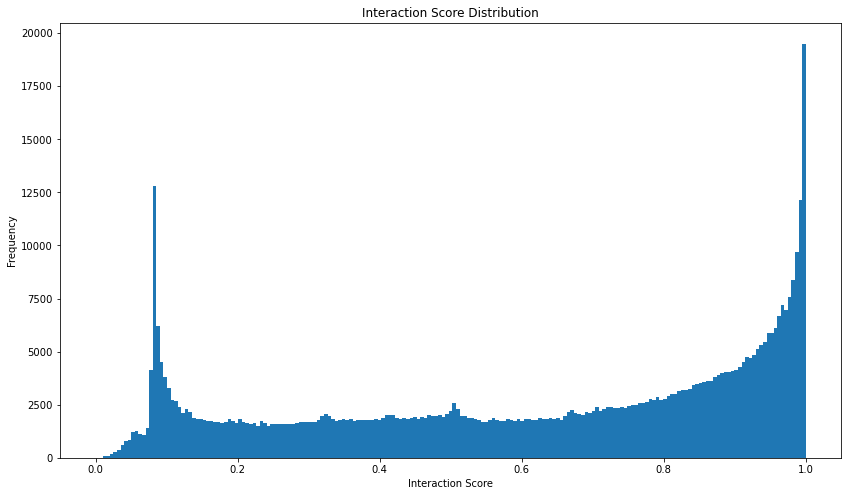

In [4]:
bins = np.linspace(0, 1, 200)
fig = plt.figure(figsize=(14, 8))
ax = plt.hist(interactions_nona.interaction_confidence, bins)
plt.xlabel('Interaction Score')
plt.ylabel('Frequency')
plt.title('Interaction Score Distribution')
interactions_nona.shape

In [6]:
print(interactions_nona)

                              #  source_databases  \
8        PhosphoPOINT,Reactome,HPRD,Spike,Biogrid   
9              HPRD,Reactome,PhosphoPOINT,Biogrid   
24                            DIP,Reactome,IntAct   
25                                  Reactome,HPRD   
26      BIND,HPRD,CORUM,MIPS-MPPI,Reactome,IntAct   
...                                           ...   
554466                              Manual upload   
554467                              Manual upload   
554468                              Manual upload   
554469                              Manual upload   
554470                              Manual upload   

                            interaction_publications  \
8                          1660465,16713569,12547834   
9                   1660465,12709393,1672777,1309330   
24      22210847,17486119,21408196,16906149,19897728   
25                                          11591728   
26                         10093054,9831708,23587463   
...                        

### Remove "complex" interactions & low confidence
* select interactions with exactly two partners
* get the edgelist -ENSG_gene -genename list
* select the confidence score>0.5

In [5]:
binary_inter = interactions_nona[interactions_nona.interaction_participants__ensembl_gene.str.count(',') == 1]
edgelist_genename = pd.concat([binary_inter.interaction_participants__genename.str.split(',', expand=True),
                                binary_inter.interaction_confidence], axis=1
                              )
edgelist_ens = pd.concat([binary_inter.interaction_participants__ensembl_gene.str.split(',', expand=True),
                                binary_inter.interaction_confidence], axis=1
                              )
edgelist_genename.set_index([np.arange(edgelist_genename.shape[0])], inplace=True)
edgelist_genename.columns = ['partner1', 'partner2', 'confidence']
high_conf_edgelist_genename = edgelist_genename[edgelist_genename.confidence > .5]
#high_conf_edgelist_genename.set_index([np.arange(high_conf_edgelist_genename.shape[0])],inplace = True)
edgelist_ens.set_index([np.arange(edgelist_ens.shape[0])], inplace=True)
edgelist_ens.columns = ['partner1', 'partner2', 'confidence']
high_conf_edgelist_ens = edgelist_ens[edgelist_ens.confidence > .5]


In [6]:
high_conf_edgelist_ens.set_index([np.arange(high_conf_edgelist_ens.shape[0])],inplace=True)
high_conf_edgelist_genename.set_index([np.arange(high_conf_edgelist_genename.shape[0])],inplace = True)

In [7]:
high_conf_edgelist_genename.to_csv('../data/ppi/CPDB_genename_edgelist_0.5.tsv', sep='\t',index = None)
high_conf_edgelist_ens.to_csv('../data/ppi/CPDB_ens_edgelist_0.5.tsv', sep='\t',index = None)
high_conf_edgelist_genename.head()
high_conf_edgelist_ens.head()

,partner1,partner2,confidence
0,ENSG00000167323,ENSG00000144935,0.597177
1,ENSG00000058668,ENSG00000089250,0.520836
2,ENSG00000069431,ENSG00000187486,0.990732
3,ENSG00000138029,ENSG00000084754,0.999980
4,ENSG00000153767,ENSG00000197265,0.973170


In [15]:
high_conf_edgelist_genename.head()

,partner1,partner2,confidence
0,ABCC9,KCNJ11,0.990732
1,HADHB,HADHA,0.999980
2,GTF2E1,GTF2E2,0.973170
3,GTF2A1,GTF2A2,0.999400
4,PARD6A,DVL2,0.995887
